In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Libraries**

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model , Input
import tensorflow.image as tfi
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, Dropout, concatenate, UpSampling2D
from keras.preprocessing.image import load_img, img_to_array
import os
import cv2
import matplotlib.pyplot as plt
from glob import glob
from keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
print(tf.__version__)

2.17.1


In [2]:
size = 256
batch = 8

**Data Load**

In [4]:
# Paths to train images, test images, and masks
train_images_path = '/kaggle/input/retina-blood-vessel/Data/train/image'
train_masks_path = '/kaggle/input/retina-blood-vessel/Data/train/mask'
test_images_path = '/kaggle/input/retina-blood-vessel/Data/test/image'
test_masks_path = '/kaggle/input/retina-blood-vessel/Data/test/mask'

In [9]:
import os
import cv2
import numpy as np
from glob import glob

def load_images_from_folder(folder):
    images = []
    for filename in glob(os.path.join(folder, '*.png')):  # Use glob.glob
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images

def resize_images(images, target_size):
    resized_images = []
    for img in images:
        resized_img = cv2.resize(img, target_size)
        resized_images.append(resized_img)
    return np.array(resized_images)


In [12]:
train_images = load_images_from_folder(train_images_path)
train_masks = load_images_from_folder(train_masks_path)
test_images = load_images_from_folder(test_images_path)
test_masks = load_images_from_folder(test_masks_path)

In [13]:
# Resize images and masks
train_images = resize_images(train_images, (256, 256))
train_masks = resize_images(train_masks, (256, 256))
test_images = resize_images(test_images, (256, 256))
test_masks = resize_images(test_masks, (256, 256))
#normalizing the images
train_images = train_images / 255.0
train_masks = train_masks / 255.0
test_images = test_images / 255.0
test_masks = test_masks / 255.0

In [14]:
#adding a channel dimension
train_images = tf.expand_dims(train_images, axis=-1)
train_masks = tf.expand_dims(train_masks, axis=-1)
test_images = tf.expand_dims(test_images, axis=-1)
test_masks = tf.expand_dims(test_masks, axis=-1)
print(f"Train images shape: {train_images.shape}")
print(f"Train masks shape: {train_masks.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test masks shape: {test_masks.shape}")

Train images shape: (80, 256, 256, 1)
Train masks shape: (80, 256, 256, 1)
Test images shape: (20, 256, 256, 1)
Test masks shape: (20, 256, 256, 1)


**Unet Architecture without attention mechanism**

In [15]:
def unet_model(input_size=(256, 256, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder
    up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    conv9 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv9)

    return model

# Create the U-Net model
model = unet_model(input_size=(256, 256, 1))

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32, 32, 512)    │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 16, 512)    │              0 │ dropout[0][0]          │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_9[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d        

 Total params: 31,030,593 (118.37 MB)

 Trainable params: 31,030,593 (118.37 MB)

 Non-trainable params: 0 (0.00 B)

**Dice and Jaccard Coefficient**

In [16]:
def jaccard_index(y_true, y_pred):
    """Calculates the Jaccard index (IoU), useful for evaluating the model's performance."""
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast ground truth
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast predictions
    intersection = tf.reduce_sum(y_true_f * y_pred_f)  # Compute intersection
    total = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection  # Total pixels
    return (intersection) / (total)


def dice_coefficient(y_true, y_pred):
    # Flatten and cast true and predicted masks to float32
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])  # Flatten and cast y_true to float32
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])  # Flatten and cast y_pred to float32
    
    # Calculate the intersection between the true and predicted masks
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    
    # Calculate the Dice coefficient using the formula
    return (2. * intersection) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f))

**Train Unet model**

In [17]:
# Using the metrics in model compilation
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',dice_coefficient,jaccard_index])

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint

## ModelCheckpoint: Save the model with the best validation loss during training
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_dice_coefficient',         # Metric to monitor 
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='max',                 # 'max' means the model with the highest metric score will be saved
    save_weights_only=False,     # Save the entire model (not just weights)
)

# Fit the model with multi-processing enabled
results = model.fit(
    train_images, 
    train_masks,
    validation_data = (test_images,test_masks),
    # Validation data ratio 
    batch_size=batch,
    epochs=100,              # Number of epochs
    callbacks=[checkpoint],# Callbacks for checkpoint and early stopping
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8410 - dice_coefficient: 0.2403 - jaccard_index: 0.1366 - loss: 0.2135
Epoch 1: val_dice_coefficient improved from -inf to 0.30889, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 460ms/step - accuracy: 0.8414 - dice_coefficient: 0.2413 - jaccard_index: 0.1373 - loss: 0.2131 - val_accuracy: 0.8525 - val_dice_coefficient: 0.3089 - val_jaccard_index: 0.1827 - val_loss: 0.1927
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8482 - dice_coefficient: 0.2899 - jaccard_index: 0.1697 - loss: 0.2058
Epoch 2: val_dice_coefficient improved from 0.30889 to 0.32649, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 458ms/step - accuracy: 0.8484 - dice_coefficient: 0.2903 - jaccard_index: 0.1701 - loss: 0.2054 - val_accuracy: 0.8502 - val_dice_coefficient: 0.3265 - val_jaccard_index: 0.1951 - val_loss: 0.2003
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.8492 - dice_

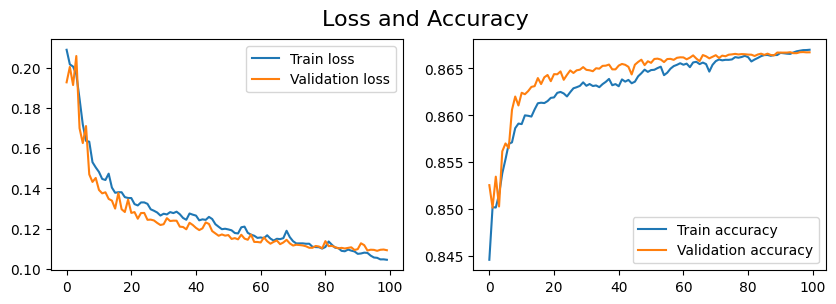

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(results.epoch, results.history["loss"], label="Train loss")
ax[0].plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(results.epoch, results.history["accuracy"], label="Train accuracy")
ax[1].plot(results.epoch, results.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

**Prediction**

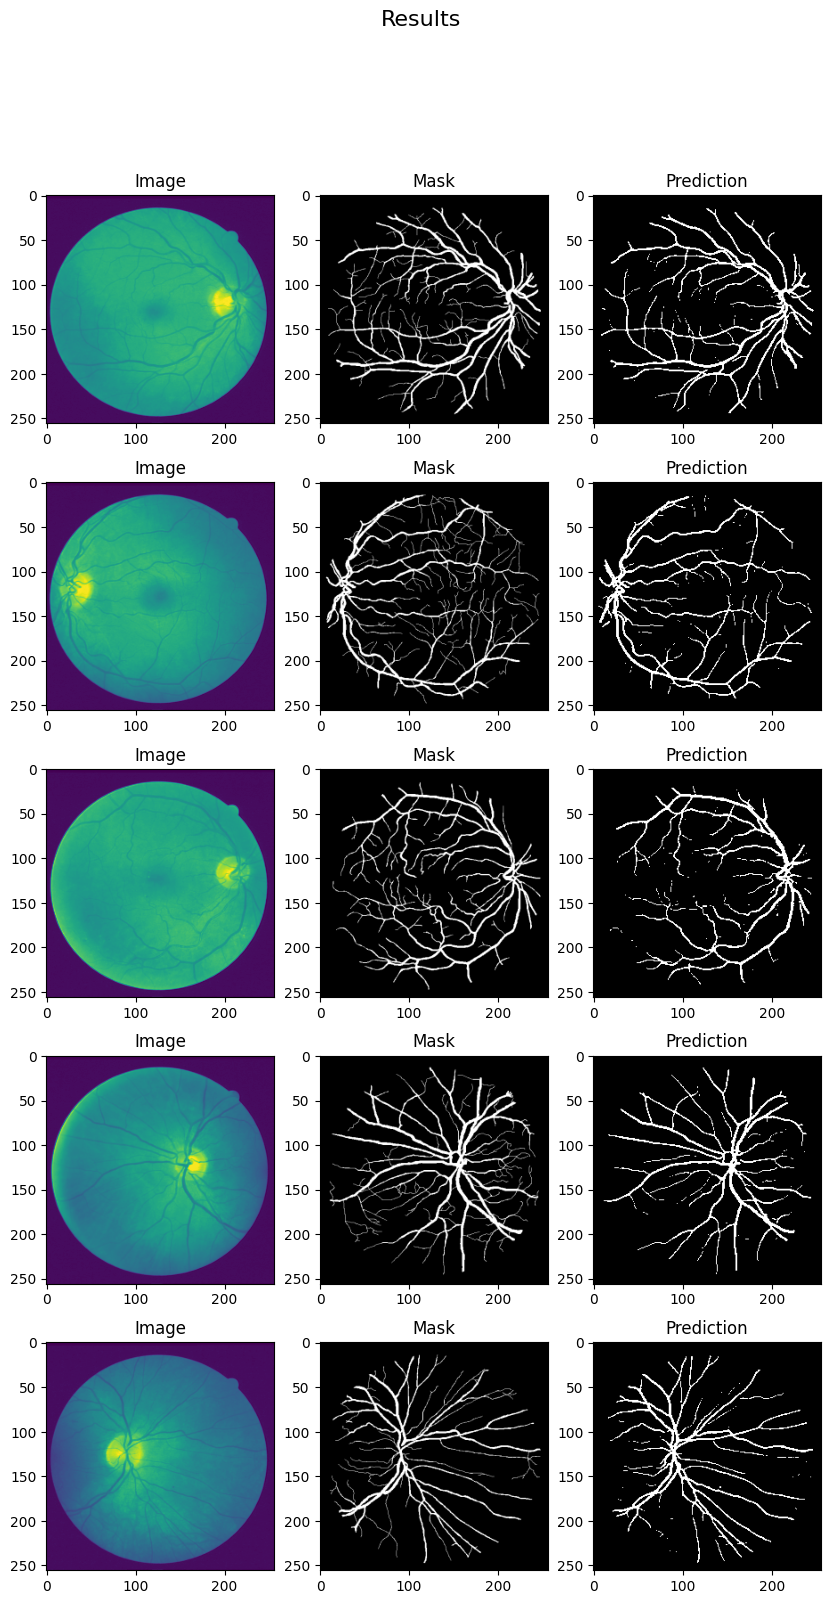

In [23]:
fig, ax = plt.subplots(5,3, figsize=(10,18))
test_images,test_masks

j = np.random.randint(0,test_images.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(test_images[j[i]])
    ax[i,0].set_title('Image')
    ax[i,1].imshow(test_masks[j[i]],cmap='gray')
    ax[i,1].set_title('Mask')
    y_hat = model.predict(np.expand_dims(test_images[j[i]],0),verbose=0)[0]
    threshold = 0.5
    binary_mask = (y_hat > threshold).astype(np.uint8)
    ax[i,2].imshow(binary_mask,cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

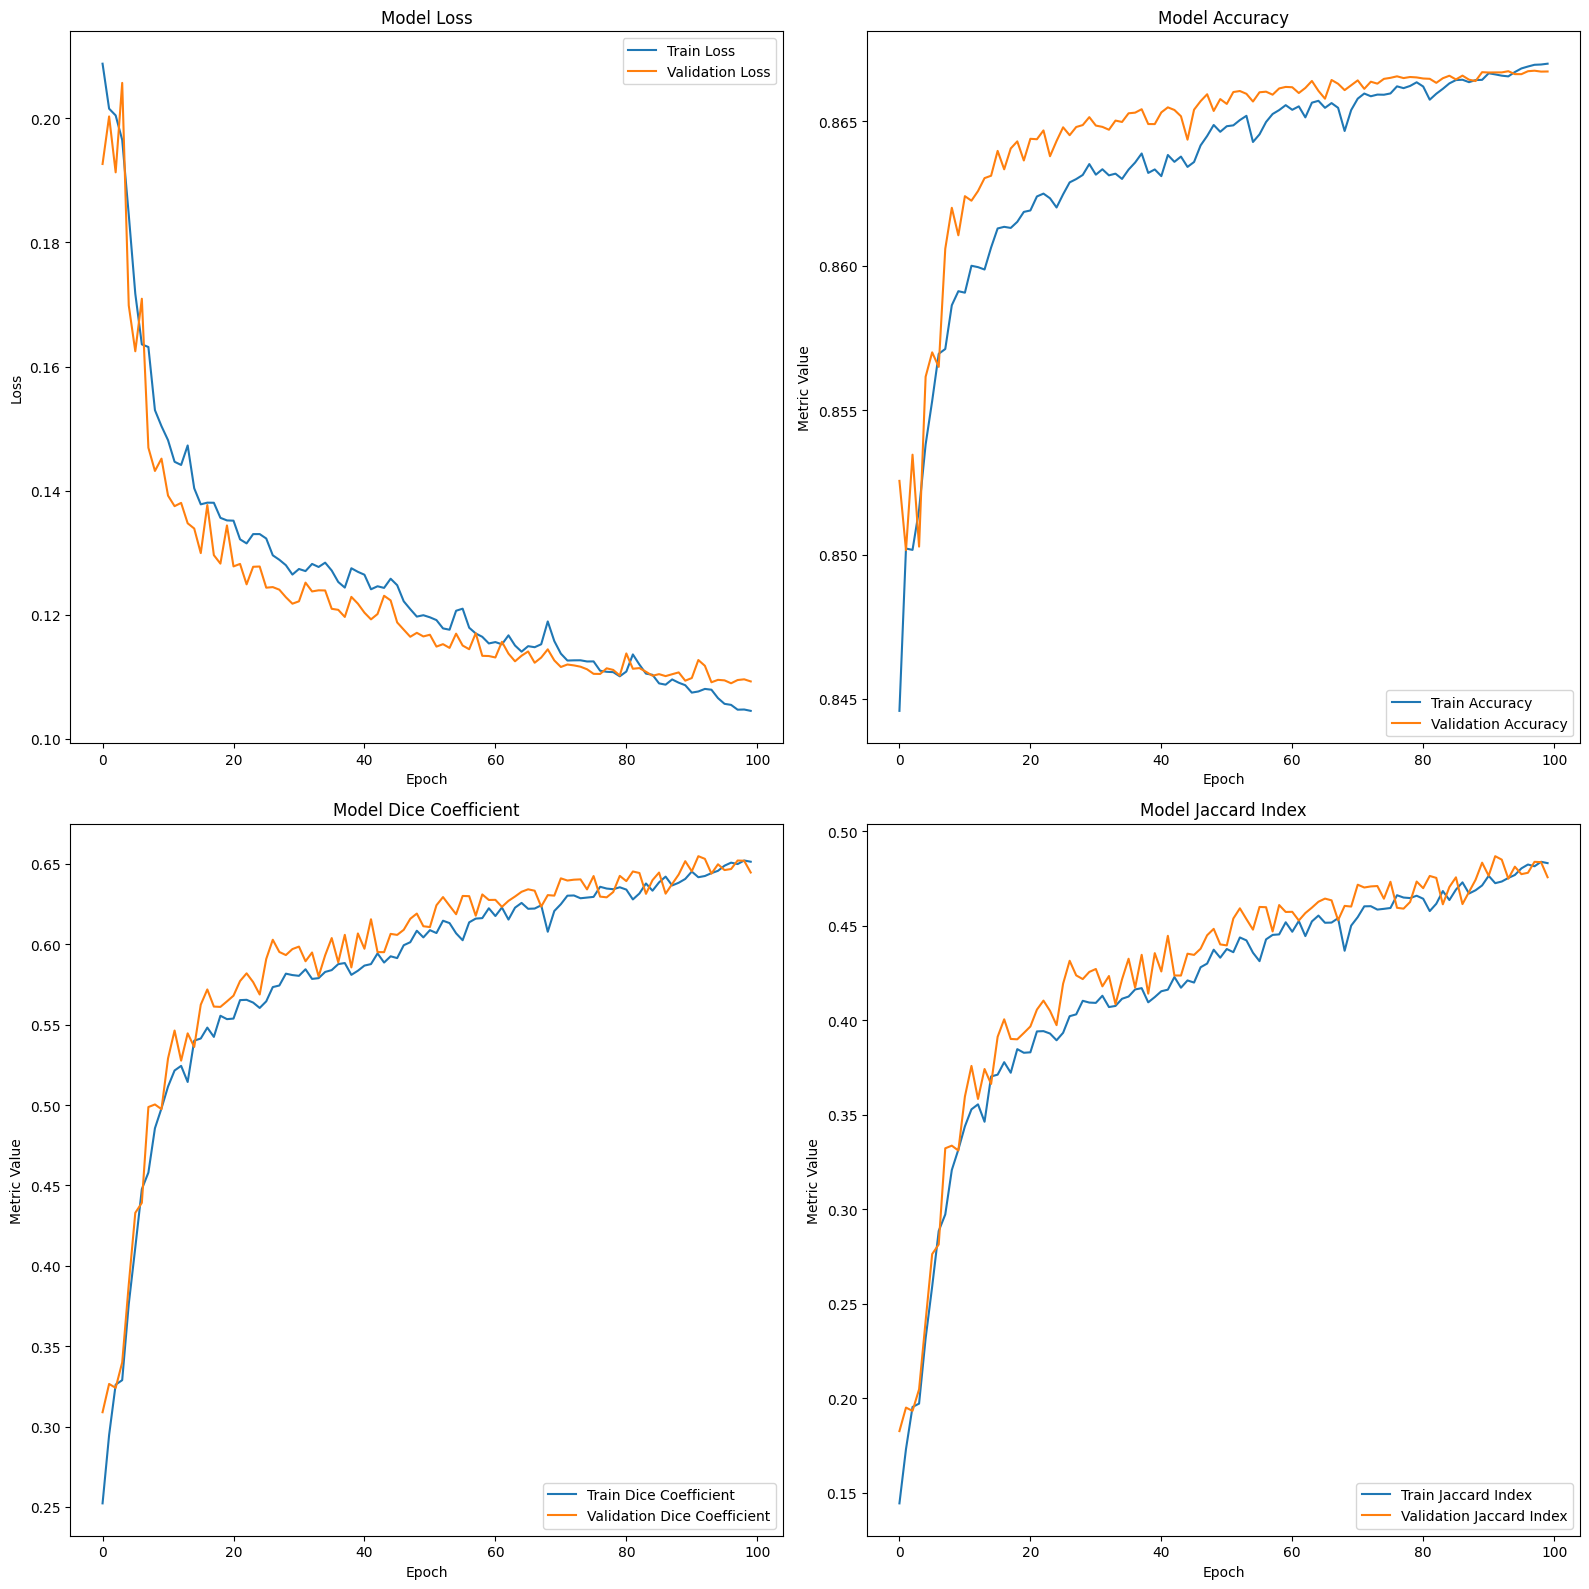

In [24]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(16, 16))

plt.subplot(221)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot training & validation accuracy values
plt.subplot(222)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

# Plot training & validation dice coefficient values
plt.subplot(223)
plt.plot(results.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(results.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend(loc='lower right')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

# Plot training & validation jaccard index values
plt.subplot(224)
plt.plot(results.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(results.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.legend(loc='lower right')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [36]:
# Extract final values
train_loss = results.history['loss'][-1]
val_loss = results.history['val_loss'][-1]
train_acc = results.history['accuracy'][-1]
val_acc = results.history['val_accuracy'][-1]
train_dice = results.history['dice_coefficient'][-1]
val_dice = results.history['val_dice_coefficient'][-1]
train_jaccard = results.history['jaccard_index'][-1]
val_jaccard = results.history['val_jaccard_index'][-1]

# Print final values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Dice Coefficient: {train_dice:.4f}")
print(f"Final Validation Dice Coefficient: {val_dice:.4f}")
print(f"Final Training Jaccard Index: {train_jaccard:.4f}")
print(f"Final Validation Jaccard Index: {val_jaccard:.4f}")


Final Training Loss: 0.1220
Final Validation Loss: 0.1176
Final Training Accuracy: 0.8642
Final Validation Accuracy: 0.8656
Final Training Dice Coefficient: 0.5984
Final Validation Dice Coefficient: 0.6183
Final Training Jaccard Index: 0.4270
Final Validation Jaccard Index: 0.4475


In [38]:
test_loss, test_acc, test_dice, test_jaccard = model.evaluate(test_images, test_masks)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test Jaccard Index: {test_jaccard:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.8667 - dice_coefficient: 0.6450 - jaccard_index: 0.4760 - loss: 0.1093
Test Loss: 0.1093
Test Accuracy: 0.8667
Test Dice Coefficient: 0.6450
Test Jaccard Index: 0.4760


**Attention mechanism with Unet**

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, UpSampling2D, Input, concatenate, Activation, Multiply, Add
from tensorflow.keras.models import Model

def attention_block(g, x):
    """
    Attention Gate: Helps the U-Net model focus on relevant features by learning to suppress irrelevant information.
    
    Parameters:
    g - Gating signal from the deeper layer
    x - Skip connection feature map

    Returns:
    Attention-weighted feature map
    """
    filters = x.shape[-1]  # Number of filters in skip connection

    theta_x = Conv2D(filters, (1, 1), strides=(1, 1), padding="same")(x)  # Transform skip connection
    phi_g = Conv2D(filters, (1, 1), strides=(1, 1), padding="same")(g)  # Transform gating signal

    add_xg = Add()([theta_x, phi_g])  # Combine both signals
    act_xg = Activation("relu")(add_xg)  # Apply ReLU activation

    psi = Conv2D(1, (1, 1), strides=(1, 1), padding="same", activation="sigmoid")(act_xg)  # Sigmoid activation to get attention map
    att_x = Multiply()([x, psi])  # Apply attention to the skip connection

    return att_x


def attention_unet(input_size=(256, 256, 1)):
    """
    Attention U-Net Model: Uses Attention Gates in skip connections.
    """
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottleneck
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)

    # Decoder with Attention Gates
    up6 = UpSampling2D(size=(2, 2))(drop5)
    up6 = Conv2D(512, (2, 2), activation='relu', padding='same')(up6)
    att6 = attention_block(up6, drop4)  # Attention Gate
    merge6 = concatenate([att6, up6], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, (2, 2), activation='relu', padding='same')(up7)
    att7 = attention_block(up7, conv3)  # Attention Gate
    merge7 = concatenate([att7, up7], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, (2, 2), activation='relu', padding='same')(up8)
    att8 = attention_block(up8, conv2)  # Attention Gate
    merge8 = concatenate([att8, up8], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, (2, 2), activation='relu', padding='same')(up9)
    att9 = attention_block(up9, conv1)  # Attention Gate
    merge9 = concatenate([att9, up9], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)
    
    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)  # Final output layer

    model = Model(inputs=inputs, outputs=conv10)

    return model


# Create Attention U-Net Model
att_unet_model = attention_unet(input_size=(256, 256, 1))

# Print Model Summary
att_unet_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 256, 256, 64)   │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_23[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_24[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 128, 128, 128)  │        147,584 │ conv2d_25[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 128)    │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6           │ (None, 32, 32, 256)    │              0 │ conv2d_28[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 32, 32, 512)    │              0 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_7           │ (None, 16, 16, 512)    │              0 │ dropout_2[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 16, 16, 1024)   │      4,719,616 │ max_pooling2d_7[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 16, 16, 1024)   │      9,438,208 │ conv2d_31[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 16, 16, 1024)   │              0 │ conv2d_32[0][0]        │
├──────────────────────

 Total params: 31,729,797 (121.04 MB)

 Trainable params: 31,729,797 (121.04 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Using the metrics in model compilation
att_unet_model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy',dice_coefficient,jaccard_index])

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

## ModelCheckpoint: Save the model with the best validation loss during training
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Path to save the model
    monitor='val_dice_coefficient',         # Metric to monitor 
    verbose=1,                  # Print messages when saving the model
    save_best_only=True,        # Save only the best model (with highest metric)
    mode='max',                 # 'max' means the model with the highest metric score will be saved
    save_weights_only=False,     # Save the entire model (not just weights)
)

# Fit the model with multi-processing enabled
results = att_unet_model.fit(
    train_images, 
    train_masks,
    validation_data = (test_images,test_masks),
    # Validation data ratio 
    batch_size=batch,
    epochs=100,              # Number of epochs
    callbacks=[checkpoint],# Callbacks for checkpoint and early stopping
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8333 - dice_coefficient: 0.1228 - jaccard_index: 0.0661 - loss: 1.6303
Epoch 1: val_dice_coefficient improved from -inf to 0.05750, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 841ms/step - accuracy: 0.8336 - dice_coefficient: 0.1232 - jaccard_index: 0.0664 - loss: 1.6006 - val_accuracy: 0.8388 - val_dice_coefficient: 0.0575 - val_jaccard_index: 0.0296 - val_loss: 0.3606
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8393 - dice_coefficient: 0.0652 - jaccard_index: 0.0339 - loss: 0.3493
Epoch 2: val_dice_coefficient improved from 0.05750 to 0.09614, saving model to best_model.keras
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 487ms/step - accuracy: 0.8393 - dice_coefficient: 0.0662 - jaccard_index: 0.0344 - loss: 0.3475 - val_accuracy: 0.8388 - val_dice_coefficient: 0.0961 - val_jaccard_index: 0.0505 - val_loss: 0.2886
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8376 - dice

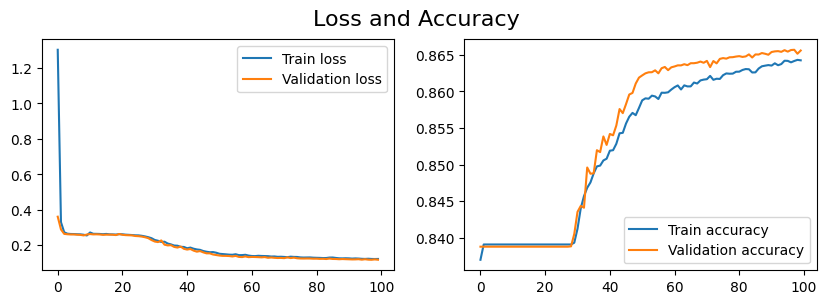

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(results.epoch, results.history["loss"], label="Train loss")
ax[0].plot(results.epoch, results.history["val_loss"], label="Validation loss")
ax[0].legend()
ax[1].plot(results.epoch, results.history["accuracy"], label="Train accuracy")
ax[1].plot(results.epoch, results.history["val_accuracy"], label="Validation accuracy")
ax[1].legend()
fig.suptitle('Loss and Accuracy', fontsize=16)
plt.show()

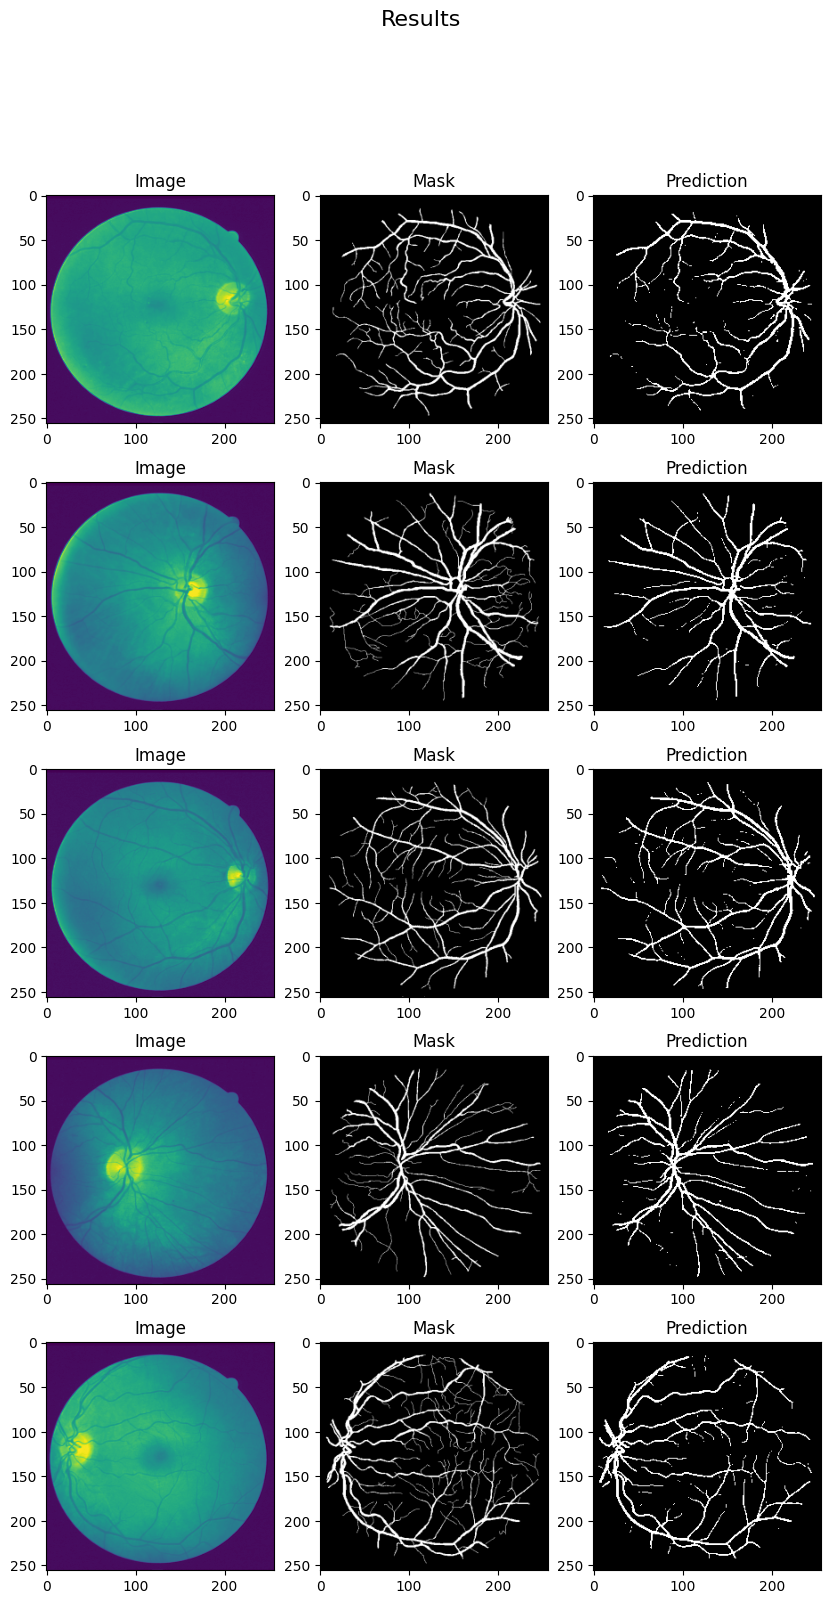

In [32]:
fig, ax = plt.subplots(5,3, figsize=(10,18))
test_images,test_masks

j = np.random.randint(0,test_images.shape[0], 5)
for i in range(5):
    ax[i,0].imshow(test_images[j[i]])
    ax[i,0].set_title('Image')
    ax[i,1].imshow(test_masks[j[i]],cmap='gray')
    ax[i,1].set_title('Mask')
    y_hat = model.predict(np.expand_dims(test_images[j[i]],0),verbose=0)[0]
    threshold = 0.5
    binary_mask = (y_hat > threshold).astype(np.uint8)
    ax[i,2].imshow(binary_mask,cmap='gray')
    ax[i,2].set_title('Prediction')
fig.suptitle('Results', fontsize=16)
plt.show()

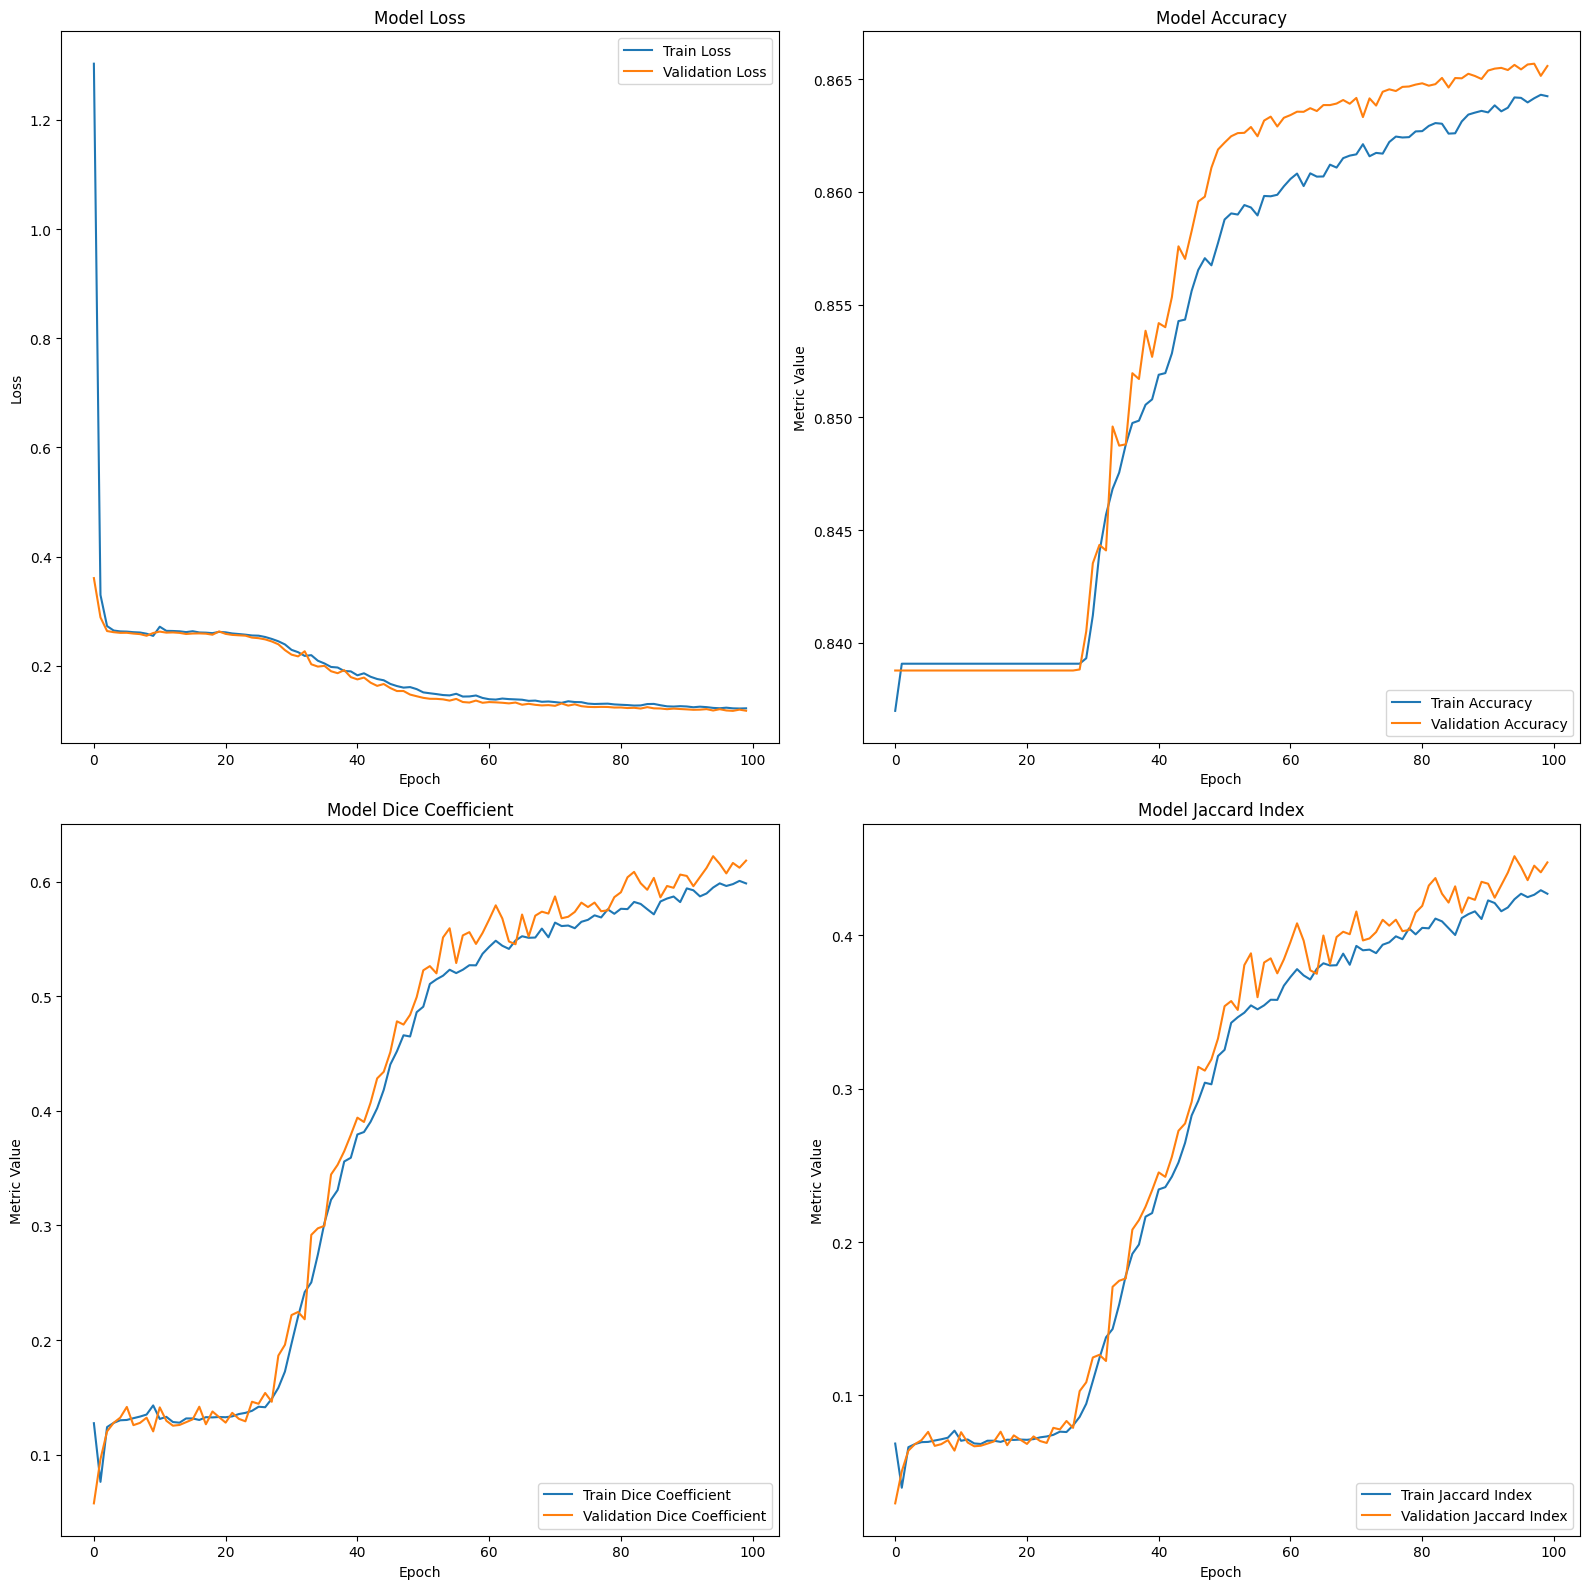

In [33]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(16, 16))

plt.subplot(221)
plt.plot(results.history['loss'], label='Train Loss')
plt.plot(results.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Plot training & validation accuracy values
plt.subplot(222)
plt.plot(results.history['accuracy'], label='Train Accuracy')
plt.plot(results.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

# Plot training & validation dice coefficient values
plt.subplot(223)
plt.plot(results.history['dice_coefficient'], label='Train Dice Coefficient')
plt.plot(results.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend(loc='lower right')
plt.title('Model Dice Coefficient')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

# Plot training & validation jaccard index values
plt.subplot(224)
plt.plot(results.history['jaccard_index'], label='Train Jaccard Index')
plt.plot(results.history['val_jaccard_index'], label='Validation Jaccard Index')
plt.legend(loc='lower right')
plt.title('Model Jaccard Index')
plt.ylabel('Metric Value')
plt.xlabel('Epoch')

plt.tight_layout()
plt.show()

In [35]:
# Extract final values
train_loss = results.history['loss'][-1]
val_loss = results.history['val_loss'][-1]
train_acc = results.history['accuracy'][-1]
val_acc = results.history['val_accuracy'][-1]
train_dice = results.history['dice_coefficient'][-1]
val_dice = results.history['val_dice_coefficient'][-1]
train_jaccard = results.history['jaccard_index'][-1]
val_jaccard = results.history['val_jaccard_index'][-1]

# Print final values
print(f"Final Training Loss: {train_loss:.4f}")
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")
print(f"Final Training Dice Coefficient: {train_dice:.4f}")
print(f"Final Validation Dice Coefficient: {val_dice:.4f}")
print(f"Final Training Jaccard Index: {train_jaccard:.4f}")
print(f"Final Validation Jaccard Index: {val_jaccard:.4f}")


Final Training Loss: 0.1220
Final Validation Loss: 0.1176
Final Training Accuracy: 0.8642
Final Validation Accuracy: 0.8656
Final Training Dice Coefficient: 0.5984
Final Validation Dice Coefficient: 0.6183
Final Training Jaccard Index: 0.4270
Final Validation Jaccard Index: 0.4475


In [39]:
test_loss, test_acc, test_dice, test_jaccard = att_unet_model.evaluate(test_images, test_masks)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice Coefficient: {test_dice:.4f}")
print(f"Test Jaccard Index: {test_jaccard:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step - accuracy: 0.8656 - dice_coefficient: 0.6179 - jaccard_index: 0.4471 - loss: 0.1176
Test Loss: 0.1176
Test Accuracy: 0.8656
Test Dice Coefficient: 0.6179
Test Jaccard Index: 0.4471
